In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train=pd.read_csv('dados/train.csv') #Dataset de treino para o modelo.
test=pd.read_csv('dados/test.csv') #Nao possui coluna dizendo se o passageiro sobreviveu ou nao

In [3]:
train.shape

(891, 12)

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Checking missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Como grande parte dos dados das cabines estão faltando não iremos utilizar essa coluna

In [7]:
# Retirada dos valores que não são importantes
train.drop(['Cabin', 'Name','Ticket'],axis = 1,inplace = True)
train['Embarked'].fillna('S', inplace = True)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

In [8]:
# Tratando os valores de idade, substituir os dados missing
# Podemos subistituir pela média, moda ou mediana
media = train['Age'].mean()
#mediana = train['Age'].median()
#moda = train['Age'].mode()

train['Age'].fillna(int(media), inplace = True)
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [9]:
# Tratamento utilizando a função IMPUTER do sklearn, porém o método acima parece mais simples.
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
train['Age'] = imp.fit_transform(train.Age.values.reshape(-1,1))

train.isnull().sum()
train['Age'].median()


29.0

# Entendendo os dados que temos

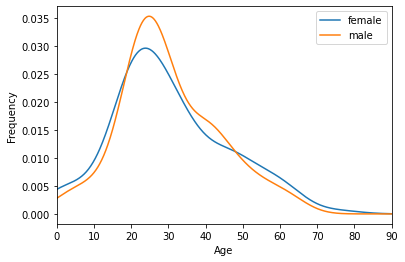

In [10]:
test.groupby('Sex').Age.plot(kind = 'kde', ylabel = 'Frequency')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('Age')
plt.xlim(0,90);

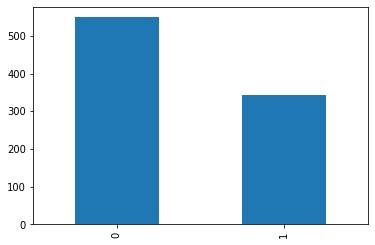

In [11]:
train.Survived.value_counts().plot(kind= 'bar');

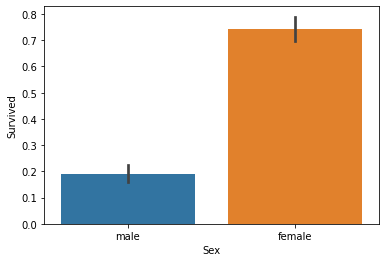

In [12]:
sns.barplot(x = 'Sex', y = 'Survived', data = train);

# Métodos de Classificação

## Serão testados vários modelos de análise preditiva e o melhor deles iremos utilizar no final.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from xgboost import XGBClassifier

In [14]:
X=train.drop('Survived',axis=1) # Separação dos parametros - Tudo menos os resultados
y=train['Survived'].astype(int) # Resultados

In [15]:
X['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [16]:
X['Sex'] = X['Sex'].map({'male': 1,'female':0})

In [17]:
X.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.0,1,0,7.2500,S
1,2,1,0,38.0,1,0,71.2833,C
2,3,3,0,26.0,0,0,7.9250,S
3,4,1,0,35.0,1,0,53.1000,S
4,5,3,1,35.0,0,0,8.0500,S


In [18]:
X['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
X['Embarked'] = X['Embarked'].map({'S': 1,'C':2,'Q':3})
X['Embarked'].value_counts()

1    646
2    168
3     77
Name: Embarked, dtype: int64

In [20]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    XGBClassifier(),
    RandomForestClassifier(n_estimators=100, max_features=3),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log = pd.DataFrame(columns=['Classifier', 'Accuracy'])

In [21]:
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

# Dicionário que irá receber o nome do modelo e a precisão obtida
acc_dict = {}

In [22]:
for clf in classifiers:
        name = clf.__class__.__name__
    
        clf.fit(X_train,y_train)
        predict=clf.predict(X_test)
        acc=accuracy_score(y_test,predict)
        if name in acc_dict:
            acc_dict[name]+=acc
        else:
            acc_dict[name]=acc

In [23]:
# Salvando os valores obtidos em log no dicionário

log['Classifier']=acc_dict.keys()
log['Accuracy']=acc_dict.values()


### Plotando a performace dos modelos utilizando o Seaborn

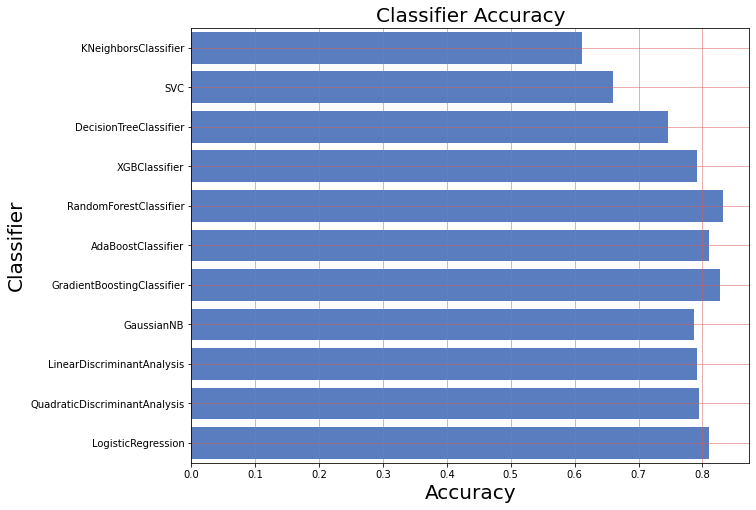

In [24]:
log.set_index([[0,1,2,3,4,5,6,7,8,9,10]])
%matplotlib inline
sns.set_color_codes("muted")
ax=plt.subplots(figsize=(10,8))
ax=sns.barplot(y='Classifier',x='Accuracy',data=log,color='b')
ax.set_xlabel('Accuracy',fontsize=20)
plt.ylabel('Classifier',fontsize=20)
plt.grid(color='r', linestyle='-', linewidth=0.5)
plt.title('Classifier Accuracy',fontsize=20);

# Utilizando o Gradient Boosting Classifier que obteve a melhor performace

## No Dataset de teste

In [25]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [26]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Limpeza dos Dados

In [27]:
#removendo as colunas desnecessárias
test.drop(['Cabin', 'Name','Ticket'],axis = 1,inplace = True)

#substituindo os valores missing
test['Embarked'].fillna('S', inplace = True)
test['Age'].fillna(int(test['Age'].mean()), inplace = True)
test['Fare'].fillna(test['Fare'].mean(), inplace = True)

#substituindo texto por números
test['Sex'] = test['Sex'].map({'male': 1,'female':0})
test['Embarked'] = test['Embarked'].map({'S': 1,'C':2,'Q':3})

test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [28]:
#help(GradientBoostingClassifier())
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
clf.predict(X_test)
clf.score(X_test,y_test)

0.8283582089552238

In [29]:
Resultado = clf.predict(test)
print(Resultado)

[0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1
 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1
 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1
 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0
 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0
 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1
 0 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 0 0 1]
